In [7]:
import numpy as np
import pandas as pd
from scipy import stats

# load original data
name = 'LD2011_2014.txt'
save_name = 'elect'
save_path = os.path.join('data', save_name)
csv_path = os.path.join(save_path, name)
data_frame = pd.read_csv(csv_path, sep=";", index_col=0, parse_dates=True, decimal=',')

In [8]:
def gen_time_covariates(tmIdxes: pd.DatetimeIndex, ):
    # feat: absAge, mo, d, wk, wkd, hrm
    covariates = np.stack(
        [(tmIdxes.year-2011)*12 + tmIdxes.dayofyear + tmIdxes.hour/24, 
        tmIdxes.month, tmIdxes.days_in_month, tmIdxes.dayofweek, 
        tmIdxes.hour + tmIdxes.minute/60], axis=-1) 
    # standardize all covariates 
    return stats.zscore(covariates, axis=0)

In [9]:
# ut time window
train_start = '2013-08-01 00:00:00'
train_end = '2014-08-31 23:45:00'
# include prev 7d as cond
test_start = '2014-08-25 00:00:00'  
test_end = '2014-09-07 23:45:00'


In [10]:
# ckp2; subset for speed
df = data_frame.loc[train_start: test_end].iloc[:, 220:300]
# same prep before partition
x = gen_time_covariates(df.index)


In [11]:
train_z = df.loc[train_start: train_end]
test_z = df.loc[test_start: test_end]
train_x = x[df.index.get_loc(train_start): df.index.get_loc(train_end)+1]
test_x = x[df.index.get_loc(test_start): df.index.get_loc(test_end)+1]
np.save(f"data/train_z.npy", train_z)
np.save(f"data/test_z.npy", test_z)
np.save(f"data/train_x.npy", train_x)
np.save(f"data/test_x.npy", test_x)

In [13]:
# ---------- visualization of prediction ----------
import torch
from MyNet import MyNet, get_data, get_model, DEVICE, COND_STEPS, PRED_STEPS

BATCH_SIZE = 256
MODEL_PATH = f"MyNet_13_23-7.pt"

train_dl, test_dl = get_data(BATCH_SIZE)
model, opt, loss_fn = get_model()
model = torch.load(MODEL_PATH)

model.eval()
with torch.no_grad():
    for data_i, data, v, label in test_dl:
        data_i, data, = data_i.to(DEVICE), data.to(DEVICE),
        v, label = v.to(DEVICE), label.to(DEVICE)
        # model output
        sigma_o = torch.zeros(label.size()).to(DEVICE)
        # scale input z
        data[..., 0] /= v
        for t in range(COND_STEPS, COND_STEPS+PRED_STEPS):
            if t == COND_STEPS:
                # feed nn data in prev 7d
                mu, sigma, hx = model(data_i, data[:, :COND_STEPS])
                mu = mu[:, -1]
                sigma = sigma[:, -1]
            else:
                # keepdims
                mu, sigma, hx = model(data_i, data[:, t:t+1], hx)
            data[:, t, 0] = mu
            sigma_o[:, t-COND_STEPS] = sigma
        # scale output
        mu_o = data[:, -PRED_STEPS:, 0] * v
        sigma_o *= v
        break


In [14]:
D = 0
label_ = label[D].cpu()
mu_ = mu_o[D].cpu()
sigma_ = sigma_o[D].cpu()

distrib = torch.distributions.normal.Normal(mu_, sigma_)
quantile = distrib.icdf(torch.tensor([[0.05], [0.95]]))


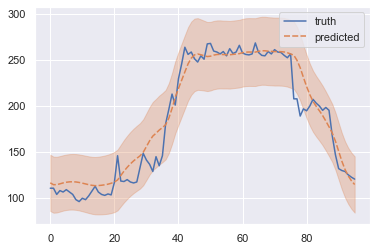

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

ax = sns.lineplot(data=pd.DataFrame({"truth": label_.numpy(), "predicted": mu_.numpy()}))
ax.fill_between(
    np.arange(0, len(quantile[0])), quantile[0].numpy(), quantile[1].numpy(), 
    alpha=0.3, color=sns.color_palette()[1])
